In [1]:
%matplotlib inline 

from lattice_generation import GeneratedLatticeImage

## Generate Data

Specify parameters to generate data:

In [2]:
N = 5 #Number of lattice sites along each axis
M = 10 #Number of pixels per lattice site
N_atom = 12 #Number of atoms to be randomly placed
N_photon = 100 #Number of photons atoms fluoresce
std = 1 #Width of the normal distribution that counts are sampled from
N_backg = 300 #Number of samples drawn from the Poisson distribution for the background noise
lam_backg = 1 #Expectation interval of the Poisson dark count event

Generate the data with specified parameters

In [3]:
lattice_image = GeneratedLatticeImage(
    N=N,
    M=M,
    N_atom=N_atom,
    N_photon=N_photon,
    std=std,
    N_backg=N_backg, 
    lam_backg=lam_backg
)

Visualize the generated data

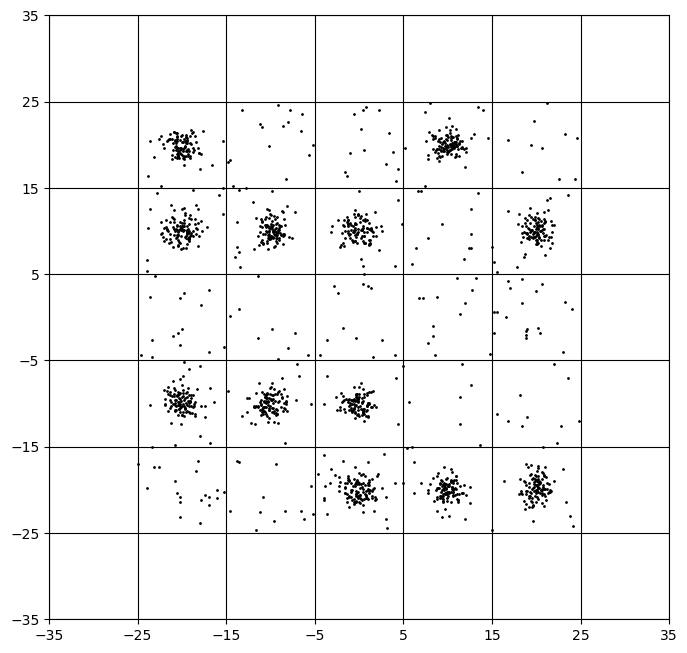

In [4]:
lattice_image.plot()

Generated data also gives the actual, binary distribution of atoms on the lattice

In [5]:
lattice_image.actual_lattice

array([[1., 0., 0., 1., 0.],
       [1., 1., 1., 0., 1.],
       [0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1.]])

## Analysis Part

In [6]:
from analysis_models import mixture_model_v0
from lattice_analyser import LatticeImageAnalyzer

Specify the model for the analysis, analyze the data with that model given the generated data results

In [7]:
# Instanciate the Analyser with the lattice_image object created above
P = LatticeImageAnalyzer(lattice_image)

# Choose analysis function
analysis_function = mixture_model_v0

# Run analysis
P.run_analysis(
    analysis_function=analysis_function
)

logp = -362.59, ||grad|| = 30.453: 100%|███████████████████████████████████████████████| 9/9 [00:00<00:00, 1511.10it/s]
logp = -73.676, ||grad|| = 0.0012705: 100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 3759.68it/s]
logp = -68.246, ||grad|| = 4.3702: 100%|█████████████████████████████████████████████| 11/11 [00:00<00:00, 5610.77it/s]
logp = -393.04, ||grad|| = 30.697: 100%|███████████████████████████████████████████████| 9/9 [00:00<00:00, 3006.67it/s]
logp = -47.32, ||grad|| = 2.7648: 100%|████████████████████████████████████████████████| 8/8 [00:00<00:00, 2675.37it/s]
logp = -421.03, ||grad|| = 25.629: 100%|███████████████████████████████████████████████| 8/8 [00:00<00:00, 4007.46it/s]
logp = -384.54, ||grad|| = 28.545: 100%|███████████████████████████████████████████████| 8/8 [00:00<00:00, 4009.85it/s]
logp = -392.9, ||grad|| = 26.455: 100%|████████████████████████████████████████████████| 9/9 [00:00<00:00, 3032.76it/s]
logp = -59.87, ||grad|| = 0.0033932: 100

The model yields the probability that each lattice site is occupied by an atom

In [8]:
P.print_occupation()

[[92.5  0.8  6.5 90.1 14.4]
 [86.2 87.6 90.7  0.  90.1]
 [ 0.   0.   0.   0.   0.4]
 [88.5 91.1 94.1  0.   0. ]
 [13.5  0.  81.5 91.6 90.9]]


Compare this result with the actual distribution of atoms

In [9]:
lattice_image.actual_lattice

array([[1., 0., 0., 1., 0.],
       [1., 1., 1., 0., 1.],
       [0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1.]])